Use ANN and randomforecast for titanic survival prediction

#install packages

In [6]:
import pandas as pd
import seaborn as sns
import re
sns.set(font_scale=1.56)
import numpy as np  
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
plt.rc("font", size=14)
import warnings
warnings.simplefilter(action='ignore')

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV

#import data

In [8]:
# loading data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_data = df_train.append(df_test)
df_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
print(df_train.shape)
print(df_test.shape)

(891, 12)
(418, 11)


#count missing data per column

In [ ]:
df_data.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

# check the data type per column

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


#check object data, which is about to be transfered to numerical data

In [ ]:
df_data.select_dtypes('object').head()

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


# Conver the data

In [9]:
df_data["Embarked"].fillna("S", inplace = True)
df_data['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [10]:
emb = pd.get_dummies(df_data['Embarked'])
del emb['C']
emb.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [11]:
# Convert Sex
df_data['Sex_Code'] = df_data['Sex'].map({'female' : 1, 'male' : 0}).astype('int')
df_data['Sex_Code'].unique()
df_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Code
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


# fill missing data

In [12]:
# Filling missing values (Fare and Age)
#df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())
df_data['Age'] = df_data['Age'].fillna(df_data['Age'].mean())
df_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Code
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,29.881138,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,1
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,NaN,3,"Ware, Mr. Frederick",male,29.881138,0,0,359309,8.0500,NaN,S,0


In [ ]:
df_data2 = pd.concat([emb, df_data], axis = 1)
df_data2

,Q,S,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Code
0,0,1,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,0
1,0,0,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,1
2,0,1,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,0,1,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,1
4,0,1,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,1,1305,NaN,3,"Spector, Mr. Woolf",male,29.881138,0,0,A.5. 3236,8.0500,NaN,S,0
414,0,0,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,1
415,0,1,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,0,1,1308,NaN,3,"Ware, Mr. Frederick",male,29.881138,0,0,359309,8.0500,NaN,S,0


# Split the data into training and testing

In [ ]:
ddf_train = df_data2[:round(len(df_train)*0.7)]
ddf_test  = df_data2[round(len(df_train)*0.7):len(df_train)] 
# Training set and labels
X_train = ddf_train.drop(labels=['Survived','PassengerId','Embarked'],axis=1)
Y_train = ddf_train['Survived']

In [ ]:
print(ddf_train.shape)
print(ddf_test.shape)
print(X_train.shape)
print(Y_train.shape)

(624, 15)
(267, 15)
(624, 12)
(624,)


In [ ]:
# Inputs set and labels
#X_train = df_train.drop(labels=['Survived','PassengerId'],axis=1)
#Y_train = df_train['Survived']
#X_train.shape

In [ ]:
X_test = ddf_test.drop(labels=['Survived','PassengerId','Embarked'],axis=1)
Y_test = ddf_test['Survived']
X_test.shape

(267, 12)

# case 1: only put Gender, Pclass and embarked in the model

In [ ]:
connect = ['Sex_Code','Pclass','Q','S']
X_train_1 =X_train[connect]
X_test_1=X_test[connect]
Y_test_1 = Y_test
Y_train_1 = Y_train
Y_test_1.shape

(267,)

##Train ANN model

## create sigmoid function for ANN

In [ ]:
import numpy as np
def sigmoid_function(x):
    return 1/ (1 + np.exp(-x))

sigmoid_function(X_train_1['Sex_Code'])

0      0.500000
1      0.731059
2      0.731059
3      0.731059
4      0.500000
         ...   
619    0.500000
620    0.500000
621    0.500000
622    0.500000
623    0.500000
Name: Sex_Code, Length: 624, dtype: float64

##Train ANN model

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_1 = sc.fit_transform(X_train_1)
X_test_1 = sc.fit_transform(X_test_1)
print(X_train_1.shape)
print(Y_train_1.shape)
print(X_test_1.shape)
print(Y_test_1.shape)

(624, 4)
(624,)
(267, 4)
(267,)


In [ ]:
# 4 -> 2 -> 1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(4, activation = 'relu', input_shape = (4,)))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
       loss='binary_crossentropy',
       metrics=['accuracy'])

In [ ]:
print(X_train_1.shape)
print(Y_train_1.shape)
print(X_test_1.shape)
print(Y_test_1.shape)

(624, 4)
(624,)
(267, 4)
(267,)


In [ ]:
history = model.fit(X_train_1, Y_train_1,
    batch_size = 128,
    epochs = 100,
    verbose = 1,
    validation_data = (X_test_1, Y_test_1))

Epoch 1/100
5/5 [==============================] - 1s 41ms/step - loss: 0.7743 - accuracy: 0.3942 - val_loss: 0.7612 - val_accuracy: 0.3596
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 0.7696 - accuracy: 0.4712 - val_loss: 0.7569 - val_accuracy: 0.6067
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 0.7651 - accuracy: 0.6042 - val_loss: 0.7526 - val_accuracy: 0.6067
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 0.7608 - accuracy: 0.6042 - val_loss: 0.7484 - val_accuracy: 0.6067
Epoch 5/100
5/5 [==============================] - 0s 8ms/step - loss: 0.7568 - accuracy: 0.6042 - val_loss: 0.7442 - val_accuracy: 0.6067
Epoch 6/100
5/5 [==============================] - 0s 8ms/step - loss: 0.7524 - accuracy: 0.6042 - val_loss: 0.7402 - val_accuracy: 0.6067
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 0.7484 - accuracy: 0.6042 - val_loss: 0.7362 - val_accuracy: 0.6067
Epoch 8/100
5/5 [=========

In [ ]:
#model.evaluate(X_test,Y_test)

In [ ]:
pred_y = (model.predict(X_test_1) > 0.5).astype(int).flatten()
from sklearn.metrics import accuracy_score
accuracy_score(Y_test_1, pred_y)

0.7865168539325843

##Sbmit the result if you'd like

In [ ]:
df_data2_test = df_data2[len(df_train):]
df_data2_test = df_data2_test.drop(labels=['Survived','PassengerId','Embarked'],axis=1)
pred_y_real = (model.predict(df_data2_test[connect]) > 0.5).astype(int).flatten()

In [ ]:
# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

#connect_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
#connect_pred = connect_Model.predict(X_Submit[connect])
df_test.shape
submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                     "Survived": pred_y_real})
submit.to_csv("submit_connect_dl.csv",index=False)

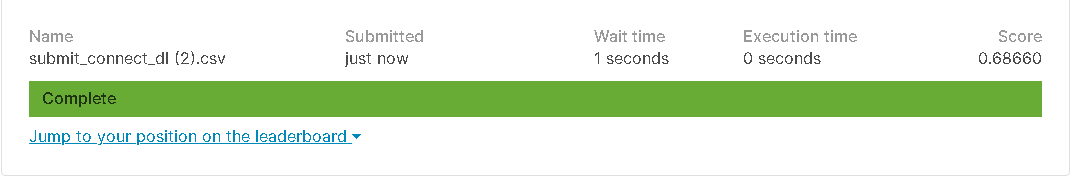

#Show Baseline per model

In [ ]:
df_data2_train=df_data2[:len(df_train)]
fit_y = (model.predict(df_data2_train[connect]) > 0.5).astype(int).flatten()
accuracy_score(fit_y, df_data2_train['Survived'])

0.6632996632996633

In [ ]:
connect = ['Sex_Code','Pclass']
connect_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
connect_Model.fit(df_data2_train[connect], df_data2_train['Survived'])
print('connect oob score :%.5f' %(connect_Model.oob_score_))

connect oob score :0.73176


Randomforest is better than ANN, use this model now and then

# Create Fare bin and Family Variables to improve the model 
> Reference: https://yulongtsai.medium.com/https-medium-com-yulongtsai-titanic-top3-8e64741cc11f



##import python package

In [ ]:
# for display dataframe
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
# ignore warning
import warnings
warnings.filterwarnings("ignore")

##Make Bin variables

In [ ]:
# Making Bins
df_data2['FareBin_4'] = pd.qcut(df_data2['Fare'], 4)
df_data2['FareBin_5'] = pd.qcut(df_data2['Fare'], 5)
df_data2['FareBin_6'] = pd.qcut(df_data2['Fare'], 6)

label = LabelEncoder()
df_data2['FareBin_Code_4'] = label.fit_transform(df_data2['FareBin_4'])
df_data2['FareBin_Code_5'] = label.fit_transform(df_data2['FareBin_5'])
df_data2['FareBin_Code_6'] = label.fit_transform(df_data2['FareBin_6'])

##Observe Cross tab with Pclass

In [ ]:
# cross tab
df_4 = pd.crosstab(df_data2['FareBin_Code_4'],df_data2['Pclass'])
df_5 = pd.crosstab(df_data2['FareBin_Code_5'],df_data2['Pclass'])
df_6 = pd.crosstab(df_data2['FareBin_Code_6'],df_data2['Pclass'])

display_side_by_side(df_4,df_5,df_6)


Pclass,1,2,3
FareBin_Code_4,,,
0,8,6,323
1,0,128,193
2,77,104,147
3,238,39,46
Pclass,1,2,3
FareBin_Code_5,,,
0,8,6,261
1,0,36,218
2,0,124,132


##Compare the accuracy of each Bin

In [ ]:
ddf_train = df_data2[:round(len(df_train)*0.7)]
ddf_test  = df_data2[round(len(df_train)*0.7):len(df_train)]
# Training set and labels
X_train = ddf_train.drop(labels=['Survived','PassengerId','Embarked'],axis=1)
Y_train = ddf_train['Survived']

In [ ]:
X_test = ddf_test.drop(labels=['Survived','PassengerId','Embarked'],axis=1)
ddf_test.shape

(267, 21)

In [ ]:
X_train_2=X_train
X_test_2=X_test
Y_test_2 = ddf_test['Survived']
Y_train_2 = Y_train

In [ ]:
b4, b5, b6 = ['Sex_Code', 'Pclass','FareBin_Code_4'], ['Sex_Code','Pclass','FareBin_Code_5'],\
['Sex_Code','Pclass','FareBin_Code_6']
b4_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b4_Model.fit(X_train_2[b4], Y_train_2)
b5_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b5_Model.fit(X_train_2[b5], Y_train_2)
b6_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b6_Model.fit(X_train_2[b6], Y_train_2)
print('b4 oob score :%.5f' %(b4_Model.oob_score_),'   LB_Public : 0.7790')
print('b5 oob score :%.5f '%(b5_Model.oob_score_),' LB_Public : 0.79425')
print('b6 oob score : %.5f' %(b6_Model.oob_score_), '  LB_Public : 0.77033')

b4 oob score :0.77564    LB_Public : 0.7790
b5 oob score :0.80609   LB_Public : 0.79425
b6 oob score : 0.81090   LB_Public : 0.77033


# case 2: Add Bin=5 in the model, fitting score improve to 80%

In [ ]:
connect = ['Sex_Code','Pclass','FareBin_Code_5']
connect_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20
                                       ,oob_score=True)
df_data2_train = df_data2[:len(df_train)]
connect_Model.fit(df_data2_train[connect], df_data2_train['Survived'])
print('connect oob score :%.5f' %(connect_Model.oob_score_))

connect oob score :0.81033


##Sbmit the result if you'd like

In [ ]:
df_data2_test = df_data2[len(df_train):]
df_data2_test = df_data2_test.drop(labels=['Survived','PassengerId','Embarked'],axis=1)
pred_y_real = (connect_Model.predict(df_data2_test[connect]) > 0.5).astype(int).flatten()

In [ ]:
# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

#connect_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
#connect_pred = connect_Model.predict(X_Submit[connect])
df_test.shape
submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                     "Survived": pred_y_real})
submit.to_csv("submit_connect_bin.csv",index=False)

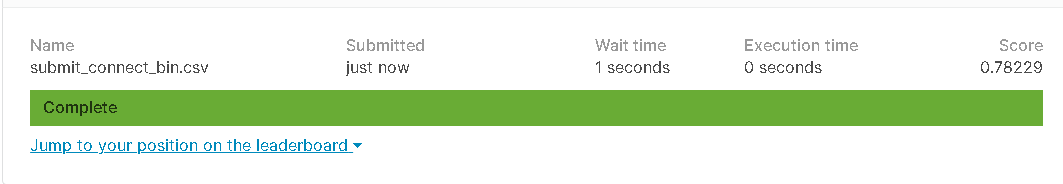

#Create Family Variable

In [ ]:
df_train['Ticket'].describe()

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

In [ ]:
# Family_size
df_data2['Family_size'] = df_data2['SibSp'] + df_data2['Parch'] + 1

In [ ]:
deplicate_ticket = []
for tk in df_data2.Ticket.unique():
    tem = df_data2.loc[df_data2.Ticket == tk, 'Fare']
    #print(tem.count())
    if tem.count() > 1:
        #print(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare']])
        deplicate_ticket.append(df_data2.loc[df_data2.Ticket == tk,['Name','Ticket','Fare','Cabin','Family_size','Survived']])
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(14)

,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
234,"Cumings, Mr. John Bradley",PC 17599,71.2833,C85,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
146,"Hilliard, Mr. Herbert Henry",17463,51.8625,E46,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


In [ ]:
# the same ticket family or friends
df_data2['Connected_Survival'] = 0.5 # default 
for _, df_grp in df_data2.groupby('Ticket'):
    if (len(df_grp) > 1):
        for ind, row in df_grp.iterrows():
            smax = df_grp.drop(ind)['Survived'].max()
            smin = df_grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                df_data2.loc[df_data2['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                df_data2.loc[df_data2['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print("people have connected information : %.0f" 
      %(df_data2[df_data2['Connected_Survival']!=0.5].shape[0]))
df_data2.groupby('Connected_Survival')[['Survived']].mean().round(3)

people keep the same ticket: 596 
people have connected information : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


# case 3: Add family variable into the model, fitting score improve to 81%

In [ ]:
ddf_train = df_data2[:round(len(df_train)*0.7)]
ddf_test  = df_data2[round(len(df_train)*0.7):len(df_train)]
# Training set and labels
X_train = ddf_train.drop(labels=['Survived','PassengerId','Embarked'],axis=1)
Y_train = ddf_train['Survived']

X_test = ddf_test.drop(labels=['Survived','PassengerId','Embarked'],axis=1)
ddf_test.shape

X_train_3=X_train
X_test_3=X_test
Y_test_3 = ddf_test['Survived']
Y_train_3 = Y_train

In [ ]:
connect = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival']
connect_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20
                                       ,oob_score=True)
connect_Model.fit(X_train_3[connect], Y_train_3)
print('connect oob score :%.5f' %(connect_Model.oob_score_))

connect oob score :0.81090


#submit the result if you'd like


In [ ]:
connect = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival']
connect_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20
                                       ,oob_score=True)
df_data3_train = df_data2[:len(df_train)]
connect_Model.fit(df_data3_train[connect], df_data3_train['Survived'])
print('connect oob score :%.5f' %(connect_Model.oob_score_))

connect oob score :0.82043


In [ ]:
df_data3_test = df_data2[len(df_train):]
df_data3_test = df_data3_test.drop(labels=['Survived','PassengerId','Embarked'],axis=1)
pred_y_real_3 = (connect_Model.predict(df_data3_test[connect]) > 0.5).astype(int).flatten()
df_data3_test.shape

(418, 20)

In [ ]:
# submits
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)

#connect_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
#connect_pred = connect_Model.predict(X_Submit[connect])
df_test.shape
submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],
                     "Survived": pred_y_real_3.astype(int)})
submit.to_csv("submit_connect_bin_family.csv",index=False)

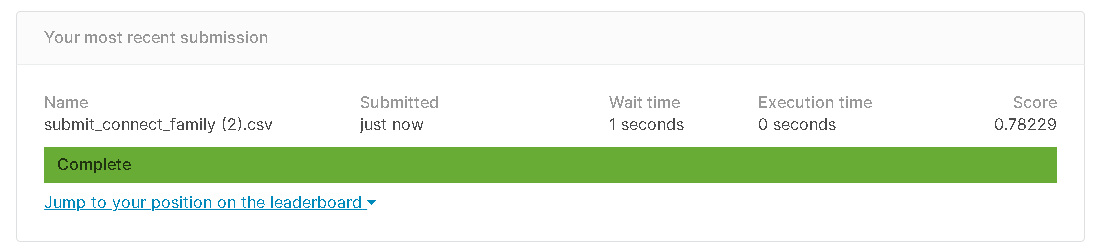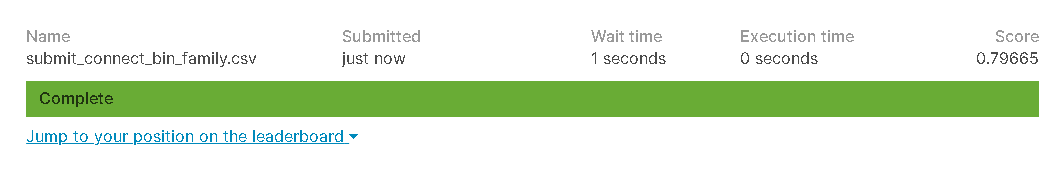